# gp120_CD4BS
## Super learner algorithm

We will need the following libraries:

In [1]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,mean_squared_error, recall_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from mlens.ensemble import SuperLearner
from sklearn.metrics import confusion_matrix,roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import graphviz
import random
import os
import mlens

import warnings
warnings.filterwarnings('ignore')

print('The graphviz version is {}.'.format(graphviz.__version__))
print('The mlens version is {}.'.format(mlens.__version__))

[MLENS] backend: threading


The graphviz version is 0.20.
The mlens version is 0.2.3.


Set some variable

In [2]:
BNAB="gp120_CD4BS"  # The 5 bnab types are:  gp120_CD4BS     gp120_V2      gp120_V3     gp41_MPER     gp41-gp120_interface
CRITERION="entropy" 
RFMAXSAMPLES=1.0 
RFMAXDEPTH=None 
SEEDNUMBER=1 

seed=SEEDNUMBER
np.random.seed(seed)
random.seed(seed)
random_state=seed

#for the graph
plt.rcParams['font.family'] = 'Arial'


# Data exploration

In [3]:
%matplotlib inline

Let us have a look at the dataset:

In [4]:
DATAPATH="input_data/"
if not os.path.exists("output/"):
    os.mkdir("output/")
OUTPUTPATH="output/"+BNAB+"/"
if not os.path.exists(OUTPUTPATH):
    os.mkdir(OUTPUTPATH)

In [5]:
data=pd.read_csv(DATAPATH+"features_table_"+BNAB+".tsv",sep='\t')
data.head(3)

,vh.gene,HCDR3.length,hcdr3.hydrophobicity,vl.gene,LCDR3.length,mut.freq,fwrs.mut.freq,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb
0,IGHV3-66,20,3.90,IGKV1-5,9,0.01,0.01,0,0,0
1,IGHV4-59,12,1.45,IGKV4-1,9,0.08,0.07,0,0,0
2,IGHV6-1,7,0.95,IGKV4-1,9,0.00,0.00,0,0,0


Let us convert the categorical labels in "vh.gene" and "vl.gene" in one-hot encoding:

In [6]:
df1=data[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW","is.bnAb"]] 
#Let's try to not use VH1.lcdr3_5 and VH1-69.VK3-20.GW NO we keep it like this
#df1=data[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","is.bnAb"]] 
df2=pd.get_dummies(data["vh.gene"])
df3=pd.get_dummies(data["vl.gene"])

In [7]:
frames=[df1,df2,df3]
df=pd.concat(frames,axis=1)

In [8]:
df.head()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb,IGHV1-18,IGHV1-2,...,IGLV4-69,IGLV5-37,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49
0,20,0.01,0.01,3.90,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,12,0.08,0.07,1.45,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0.00,0.00,0.95,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,0.18,0.15,2.10,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,0.01,0.01,3.60,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.shape

(15016, 123)

In [10]:
df.describe()

,HCDR3.length,mut.freq,fwrs.mut.freq,hcdr3.hydrophobicity,LCDR3.length,VH1.lcdr3_5,VH1-69.VK3-20.GW,is.bnAb,IGHV1-18,IGHV1-2,...,IGLV4-69,IGLV5-37,IGLV5-39,IGLV5-45,IGLV5-48,IGLV6-57,IGLV7-43,IGLV7-46,IGLV8-61,IGLV9-49
count,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.0,15016.000000,15016.000000,15016.000000,...,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000,15016.000000
mean,15.526705,0.073363,0.058054,2.616353,9.672416,0.001931,0.0,0.003596,0.034030,0.038292,...,0.010722,0.000466,0.000133,0.002397,0.000200,0.008458,0.005527,0.007991,0.010456,0.001532
std,3.778669,0.064633,0.057520,1.317874,1.139068,0.043905,0.0,0.059862,0.181313,0.191908,...,0.102993,0.021587,0.011540,0.048907,0.014134,0.091579,0.074143,0.089040,0.101720,0.039108
min,4.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,0.000000,0.000000,1.650000,9.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,0.070000,0.050000,2.450000,9.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.000000,0.120000,0.090000,3.400000,10.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.000000,0.510000,0.540000,8.950000,22.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Now let's try the Super learner algorithm

In [11]:
# create a list of base-models
def get_models():
 models = list()
 models.append(DecisionTreeClassifier())
 models.append(SVC(gamma='scale', probability=True))
 models.append(KNeighborsClassifier())
 models.append(AdaBoostClassifier())
 models.append(BaggingClassifier(n_estimators=10))
 models.append(RandomForestClassifier(n_estimators=10))
 models.append(ExtraTreesClassifier(n_estimators=10))
 return models
 

In [12]:
# create the super learner, we use the precision score as scorer since we want the lowest number of FP
def get_super_learner(X):
 ensemble = SuperLearner(scorer=precision_score, folds=10, shuffle=True, sample_size=len(X),random_state=random_state)
 # add base models
 models = get_models()
 ensemble.add(models)
 # add the meta model
 ensemble.add_meta(LogisticRegression(solver='lbfgs',random_state=random_state))
 return ensemble
 

In [13]:
# create the inputs and outputs
#split the data
mydf=df.copy()
X = mydf.loc[:,mydf.columns != 'is.bnAb'] # Features
y = mydf.loc[:,'is.bnAb'] # Target variable
X=X.to_numpy()
y=y.to_numpy()
# split
X, X_val, y, y_val = train_test_split(X, y, test_size=0.25,random_state=random_state)
print('Train', X.shape, y.shape, 'Test', X_val.shape, y_val.shape)
# create the super learner
ensemble = get_super_learner(X)
# fit the super learner
ensemble.fit(X, y)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
yhat = ensemble.predict(X_val)
print('Super Learner, accuracy: %.3f' % (accuracy_score(y_val, yhat) * 100))
print('Super Learner, precision: %.3f' % (precision_score(y_val, yhat) * 100))
print('Super Learner, RMSE: %.3f' % (mean_squared_error(y_val, yhat)))
#ft is for fitting time, pt for prediction time, m for model and s for super model

Train (11262, 122) (11262,) Test (3754, 122) (3754,)
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.68     0.37  5.84  0.05  0.16  0.03
layer-1  baggingclassifier            0.64     0.36  0.98  0.05  0.07  0.01
layer-1  decisiontreeclassifier       0.54     0.30  0.37  0.05  0.00  0.00
layer-1  extratreesclassifier         0.90     0.30  1.13  0.46  0.09  0.07
layer-1  kneighborsclassifier         0.59     0.45  0.02  0.01  0.76  0.23
layer-1  randomforestclassifier       0.80     0.40  0.38  0.02  0.03  0.01
layer-1  svc                          0.00     0.00  2.82  0.33  0.01  0.00

Super Learner, accuracy: 99.814
Super Learner, precision: 100.000
Super Learner, RMSE: 0.002


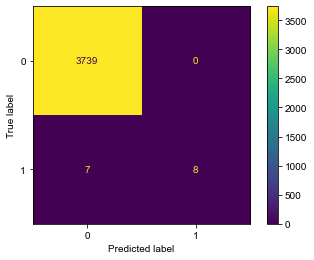

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
cm=confusion_matrix(y_val, yhat)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [15]:
#write out performance scores
# Antigenic site,TP,FP,TN,FN,AUC,Accuracy,Recall,Precision
tn, fp, fn, tp = cm.ravel()
acc= str(round(accuracy_score(y_val, yhat), 2))
prec= str(round(precision_score(y_val, yhat), 2))
recall= str(round(recall_score(y_val, yhat), 2))
auc= str(round(roc_auc_score(y_val, yhat), 2))
print(BNAB+","+str(tp)+","+str(fp)+","+str(tn)+","+str(fn)+","+auc+","+acc+","+recall+","+prec)

gp120_CD4BS,8,0,3739,7,0.77,1.0,0.53,1.0


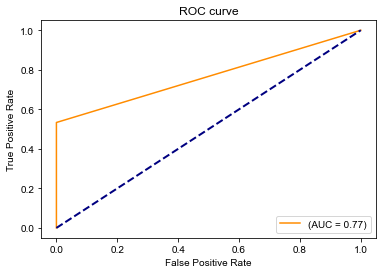

In [16]:
fpr,tpr,thresholds=roc_curve(y_val, yhat)
AUC=roc_auc_score(y_val, yhat)
plt.plot(fpr,tpr,color="darkorange",label="(AUC = %0.2f)"%AUC)
plt.plot([0, 1],[0, 1],color="navy",lw=2,linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.savefig(OUTPUTPATH+'superlearner_ROCcurve_'+BNAB+'.pdf', bbox_inches='tight')

### The precision and accuracy are very good, let's test it with our HIV+ donors

In [17]:
#test HIV donor
combined = pd.DataFrame()
experiments=['D1','D2','B3','G3','S4','G4']
for EXP in experiments:
    EXPPATH="HIVdonors_AIRR/"+EXP+"/" # or  "HIVdonors_FILES/"+EXP+"/"
    donordata=pd.read_csv(EXPPATH+EXP+"_featuresTable.tsv",sep='\t')
    df1=donordata[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW"]]
    df2=pd.get_dummies(donordata["vh.gene"])
    df3=pd.get_dummies(donordata["vl.gene"])
    frames=[df1,df2,df3]
    df=pd.concat(frames,axis=1)

    df.head()
    cols=(mydf.loc[:,mydf.columns != 'is.bnAb']).columns.values. tolist()
    training=pd.DataFrame(X,columns=cols)

    #missing columns from the training dataset
    missing=[i for i in training if i not in df.columns]
    print("- Missing columns to add:")
    print(missing)

    for miss in missing:
        df[miss]="0"

    #extra column to remove from the donor (some VK)
    extra = [i for i in df if i not in training.columns]
    print("- Extra columns to remove:")
    print(extra)
    df = df.drop(columns=extra)

    df.head()

    #we predict with the super learner
    predictions_donor=ensemble.predict(df) 
    valTable= df.copy()
    valTable['predicted'] = predictions_donor

    dataf=valTable[(valTable['predicted'] == 1) ]
    dataf=dataf[["HCDR3.length","mut.freq","fwrs.mut.freq","hcdr3.hydrophobicity","LCDR3.length","VH1.lcdr3_5","VH1-69.VK3-20.GW"]]
    #print(dataf) #to check we have the correct rows
    bnab_indexes = dataf.index.to_numpy()
    print("- Found indexes:")
    print(bnab_indexes)
    print("\nNumber of superlearner potential "+BNAB+" BnAb with experiment "+EXP+": "+str(len(bnab_indexes))+"\n")
    print(EXP+","+BNAB+","+str(len(bnab_indexes)))
    bnab_data = donordata.iloc[bnab_indexes]

    if not bnab_data.empty:
        print(bnab_data)
        #IF use of R script to make features just do and comment the 3 lines after:
        #df_to_write=bnab_data
        airr_data=pd.read_csv(EXPPATH+"AIRR_file_"+EXP+".tsv",sep='\t')
        df_to_write= pd.merge(bnab_data,airr_data,on="sequence_id")
        df_to_write['predicted_ag_site']=BNAB
        combined = pd.concat([combined,df_to_write])

outfile=OUTPUTPATH+'potential_bnabs_superlearner.tsv'
#remove file if exists from previous analysis (because of stochastic variation)
if os.path.exists(outfile):
    os.remove(outfile)

if not combined.empty:
    combined.to_csv(outfile, sep = "\t",index=False)

- Missing columns to add:
['IGHV1-69-2', 'IGHV3-33', 'IGHV4-31', 'IGHV4/OR15-8', 'IGKV1-NL1', 'IGKV2-29', 'IGKV2D-30', 'IGKV3/OR2-268', 'IGKV3D-11', 'IGLV10-54', 'IGLV3-12', 'IGLV5-48']
- Extra columns to remove:
['IGLV3-16', 'IGLV4-3']
- Found indexes:
[]

Number of superlearner potential gp120_CD4BS BnAb with experiment D1: 0

D1,gp120_CD4BS,0
- Missing columns to add:
['IGHV3-69-1', 'IGHV4-28', 'IGHV4/OR15-8', 'IGHV7-4-1', 'IGKV1-NL1', 'IGKV1D-13', 'IGKV2-29', 'IGKV2D-30', 'IGKV3/OR2-268', 'IGKV3D-11', 'IGLV3-12', 'IGLV5-37', 'IGLV5-48']
- Extra columns to remove:
['IGLV3-22', 'IGLV5-52']
- Found indexes:
[]

Number of superlearner potential gp120_CD4BS BnAb with experiment D2: 0

D2,gp120_CD4BS,0
- Missing columns to add:
['IGHV4/OR15-8', 'IGKV3/OR2-268', 'IGKV3D-11', 'IGKV5-2', 'IGLV5-48']
- Extra columns to remove:
['IGHV3-38-3', 'IGLV3-16']
- Found indexes:
[]

Number of superlearner potential gp120_CD4BS BnAb with experiment B3: 0

B3,gp120_CD4BS,0
- Missing columns to add:
['I

In [204]:
os.system('jupyter nbconvert --to html SuperLearner_PUB.ipynb')

[NbConvertApp] Converting notebook SuperLearner_PUB.ipynb to html
[NbConvertApp] Writing 674141 bytes to SuperLearner_PUB.html


0

In [208]:
#concatenate all files together
combined=pd.DataFrame()
bnabs=["gp120_CD4BS","gp120_V2","gp120_V3","gp41_MPER","gp41-gp120_interface"]
for bnab in bnabs:
    bnabpath='output/'+bnab+"/"
    file_path=bnabpath+'potential_bnabs_superlearner.tsv'
    if os.path.exists(file_path):
        data=pd.read_csv(file_path,sep='\t')
        combined = pd.concat([combined,data])
combined.insert(0, 'predicted_ag_site', combined.pop('predicted_ag_site'))
combined.to_csv('output/all_potential_bnabs_superlearner.tsv', sep = "\t",index=False)
